=== Huấn luyện thường ===
Epoch 0: loss=577.9385, val_loss=603.0869, val_mae=22.7949
Epoch 10: loss=63.2427, val_loss=59.9098, val_mae=6.0732
Epoch 20: loss=28.2057, val_loss=27.4835, val_mae=4.0865
Epoch 30: loss=20.5986, val_loss=23.3094, val_mae=3.6407
Epoch 40: loss=19.8259, val_loss=22.4216, val_mae=3.4201
Epoch 50: loss=17.5030, val_loss=22.6911, val_mae=3.2986
Early stopping tại epoch 53

Dự đoán cho ngôi nhà đầu tiên: 7.79 (nghìn USD)
MAE trên tập kiểm tra cuối cùng: 3.3187

=== K-Fold Validation ===

--- Fold 1/4 ---
Epoch 0: loss=577.6650, val_loss=565.9150, val_mae=21.6936
Epoch 10: loss=138.4886, val_loss=89.2885, val_mae=7.1407
Epoch 20: loss=37.2776, val_loss=28.1163, val_mae=3.5062
Epoch 30: loss=33.1089, val_loss=22.5391, val_mae=3.2477
Epoch 40: loss=24.7837, val_loss=18.4940, val_mae=3.0709

--- Fold 2/4 ---
Epoch 0: loss=584.8682, val_loss=549.0669, val_mae=21.8535
Epoch 10: loss=143.7267, val_loss=97.0738, val_mae=7.8487
Epoch 20: loss=37.2194, val_loss=23.2997, val

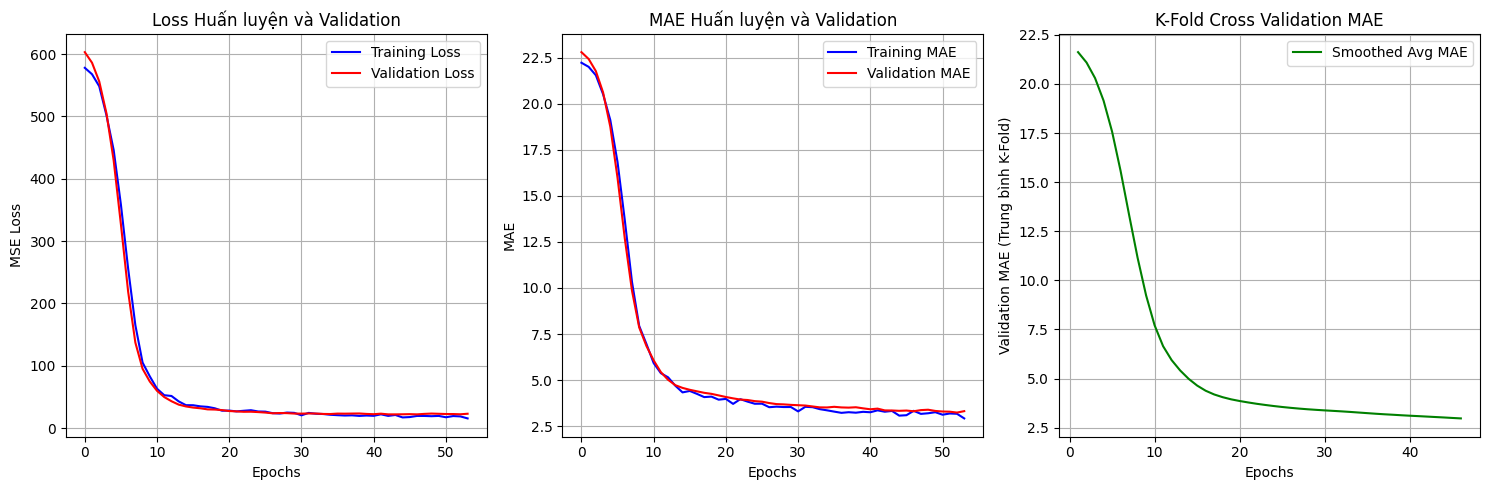


=== So sánh dự đoán vs thực tế (5 mẫu đầu) ===
Mẫu 1: Dự đoán=7.79, Thực tế=7.20
Mẫu 2: Dự đoán=16.61, Thực tế=18.80
Mẫu 3: Dự đoán=20.52, Thực tế=19.00
Mẫu 4: Dự đoán=32.78, Thực tế=27.00
Mẫu 5: Dự đoán=25.35, Thực tế=22.20


In [52]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing

# Tắt eager execution để chạy ở graph mode (TensorFlow 1.x style)
tf.disable_eager_execution()

# 1. Tải dữ liệu
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 2. Chuẩn hóa dữ liệu
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# 3. Định nghĩa mô hình sử dụng tf.compat.v1
def build_model(input_shape):
    tf.reset_default_graph()  # Reset graph để tránh xung đột giữa các fold
    
    # Placeholders cho dữ liệu
    x = tf.placeholder(tf.float32, shape=[None, input_shape], name='x')
    y_true = tf.placeholder(tf.float32, shape=[None], name='y_true')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    # Layer 1 với L2 regularization
    w1 = tf.Variable(tf.random.normal([input_shape, 64], stddev=0.1), name='w1')
    b1 = tf.Variable(tf.zeros([64]), name='b1')
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
    
    # Dropout layer - chỉ áp dụng khi training=True
    dropout_rate = 0.3
    h1_dropout = tf.cond(is_training, 
                        lambda: tf.nn.dropout(h1, rate=dropout_rate),
                        lambda: h1)
    
    # Layer 2
    w2 = tf.Variable(tf.random.normal([64, 32], stddev=0.1), name='w2')
    b2 = tf.Variable(tf.zeros([32]), name='b2')
    h2 = tf.nn.relu(tf.matmul(h1_dropout, w2) + b2)
    
    # Output layer
    w3 = tf.Variable(tf.random.normal([32, 1], stddev=0.1), name='w3')
    b3 = tf.Variable(tf.zeros([1]), name='b3')
    y_pred = tf.matmul(h2, w3) + b3
    y_pred = tf.squeeze(y_pred)  # Loại bỏ dimension thừa
    
    # Loss với L2 regularization
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    l2_loss = 0.01 * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3))
    total_loss = mse_loss + l2_loss
    
    # Metric
    mae_metric = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(total_loss)
    
    return x, y_true, is_training, y_pred, total_loss, mae_metric, train_op

# 4. Hàm huấn luyện mô hình với early stopping
def train_model(session, x, y_true, is_training, train_op, total_loss, mae_metric, y_pred,
                train_data, train_targets, val_data, val_targets, 
                epochs=100, batch_size=32, patience=10):
    n = len(train_data)
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Shuffle dữ liệu
        indices = np.random.permutation(n)
        shuffled_train_data = train_data[indices]
        shuffled_train_targets = train_targets[indices]
        
        epoch_losses = []
        epoch_maes = []
        
        # Mini-batch training
        for i in range(0, n, batch_size):
            x_batch = shuffled_train_data[i:i+batch_size]
            y_batch = shuffled_train_targets[i:i+batch_size]
            
            _, loss, mae = session.run([train_op, total_loss, mae_metric], 
                                     feed_dict={x: x_batch, y_true: y_batch, is_training: True})
            epoch_losses.append(loss)
            epoch_maes.append(mae)
        
        # Validation
        val_loss, val_mae = session.run([total_loss, mae_metric], 
                                       feed_dict={x: val_data, y_true: val_targets, is_training: False})
        
        # Lưu history
        history['loss'].append(np.mean(epoch_losses))
        history['val_loss'].append(val_loss)
        history['mae'].append(np.mean(epoch_maes))
        history['val_mae'].append(val_mae)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss={np.mean(epoch_losses):.4f}, val_loss={val_loss:.4f}, val_mae={val_mae:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping tại epoch {epoch}")
                break
    
    return history

# 5. K-Fold Cross Validation
def k_fold_validation(k, data, targets, num_epochs=100):
    fold_size = len(data) // k
    all_mae_histories = []
    
    for i in range(k):
        print(f"\n--- Fold {i+1}/{k} ---")
        
        # Chia dữ liệu
        val_data = data[i*fold_size:(i+1)*fold_size]
        val_targets = targets[i*fold_size:(i+1)*fold_size]
        partial_train_data = np.concatenate([data[:i*fold_size], data[(i+1)*fold_size:]], axis=0)
        partial_train_targets = np.concatenate([targets[:i*fold_size], targets[(i+1)*fold_size:]], axis=0)
        
        # Xây dựng mô hình mới cho mỗi fold
        x, y_true, is_training, y_pred, total_loss, mae_metric, train_op = build_model(data.shape[1])
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            history = train_model(sess, x, y_true, is_training, train_op, total_loss, mae_metric, y_pred,
                                partial_train_data, partial_train_targets, val_data, val_targets, 
                                epochs=num_epochs, patience=5)
            all_mae_histories.append(history['val_mae'])
    
    # Tính trung bình MAE qua tất cả các fold
    min_length = min(len(h) for h in all_mae_histories)
    trimmed_histories = [h[:min_length] for h in all_mae_histories]
    average_mae_history = np.mean(trimmed_histories, axis=0)
    
    return average_mae_history

# 6. Chạy huấn luyện thường
print("=== Huấn luyện thường ===")
x, y_true, is_training, y_pred, total_loss, mae_metric, train_op = build_model(train_data.shape[1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history = train_model(sess, x, y_true, is_training, train_op, total_loss, mae_metric, y_pred,
                         train_data, train_targets, test_data, test_targets, epochs=100)
    
    # Dự đoán trên test set
    test_predictions = sess.run(y_pred, feed_dict={x: test_data, is_training: False})
    final_test_mae = sess.run(mae_metric, feed_dict={x: test_data, y_true: test_targets, is_training: False})

print(f"\nDự đoán cho ngôi nhà đầu tiên: {test_predictions[0]:.2f} (nghìn USD)")
print(f"MAE trên tập kiểm tra cuối cùng: {final_test_mae:.4f}")

# 7. K-Fold Validation
print("\n=== K-Fold Validation ===")
average_mae_history = k_fold_validation(4, train_data, train_targets, num_epochs=50)

# 8. Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label="Training Loss", color='blue')
plt.plot(history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss Huấn luyện và Validation")
plt.legend()
plt.grid(True)

# Plot 2: MAE curves
plt.subplot(1, 3, 2)
plt.plot(history['mae'], label="Training MAE", color='blue')
plt.plot(history['val_mae'], label="Validation MAE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE Huấn luyện và Validation")
plt.legend()
plt.grid(True)

# Plot 3: K-Fold MAE với smoothing
plt.subplot(1, 3, 3)
if len(average_mae_history) > 5:
    smoothed_mae = np.convolve(average_mae_history, np.ones(5)/5, mode='valid')
    plt.plot(range(1, len(smoothed_mae)+1), smoothed_mae, label="Smoothed Avg MAE", color='green')
else:
    plt.plot(range(1, len(average_mae_history)+1), average_mae_history, label="Avg MAE", color='green')
plt.xlabel("Epochs")
plt.ylabel("Validation MAE (Trung bình K-Fold)")
plt.title("K-Fold Cross Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 9. So sánh một số dự đoán với giá trị thực tế
print("\n=== So sánh dự đoán vs thực tế (5 mẫu đầu) ===")
for i in range(5):
    print(f"Mẫu {i+1}: Dự đoán={test_predictions[i]:.2f}, Thực tế={test_targets[i]:.2f}")